In [1]:
#Standard data analytical libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import os, warnings, time, dmba
import scikitplot as skplt #pip install scikit-plot

#Data Mining Book Libraries
from dmba import liftChart, gainsChart,regressionSummary, classificationSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection, adjusted_r2_score, AIC_score, BIC_score
from os.path import exists
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score,accuracy_score, roc_curve, auc,roc_auc_score,plot_confusion_matrix,confusion_matrix,r2_score
#Classification 
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression,  LinearRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import imblearn
from imblearn.over_sampling import SMOTE

# Used to save keystrokes when wanting to print something. Now we can just use
# p("Hello") instead of print("Hello")
p = print
# import csv
# import re

#Change this value if you are not using o_desktop
computer = 'o_desktop'
#computer = 'other'
if (computer == 'o_desktop'):
    os.environ['NUMEXPR_MAX_THREADS'] = '24'
else:
    #default is 4 or 8
    os.environ['NUMEXPR_MAX_THREADS'] = '8'

# For future use.
# import threading
# import multiprocessing

### Data Preparation (Wrangling and Pre-Processing)<a class="anchor" id="preprocess"></a>

To prepare the data for modeling, a number of preprocessing steps were taken. 
First...

In [2]:
repo_directory = r"C:/ADS_599_Final/"
data_folder_directory = r"C:/ADS_599_Final/Data_Folder/"
df_features_file = "C:/ADS_599_Final/Data_Folder/training_set_features.csv"
df_labels_file = "C:/ADS_599_Final/Data_Folder/training_set_labels.csv"
df = pd.read_csv(df_features_file)
df_labels = pd.read_csv(df_labels_file)

#This is a very important step.
#We are combining our feature and target/label variables.
df = df.join(df_labels.set_index('respondent_id'), on='respondent_id')

df.head(5)



,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


Show unique values per column in preparation of data cleaning and transformation.
Only needs to be done once since the files saved in the repo.

In [3]:
uniq_values_file = "unique_values_in_column.txt"
uniq_counts_file = 'unique_counts_in_column.txt'
if not exists(data_folder_directory + uniq_values_file):
    for col in df:
        #Unique values in each column
        with open(uniq_values_file, 'a') as f:
            f.write(str(df[col].unique()))
            f.write('\n')
        p(df[col].unique())

if not exists(data_folder_directory+ uniq_counts_file):
    for col in df:
        #Occurance of each unique row value
        #must set dropna=False
        with open(uniq_counts_file, 'a') as f:
            f.write( str(df[col].value_counts(dropna=False) ))
            f.write('\n')
        p(df[col].value_counts())


We show the number of null values per column below.

In [4]:
p("The null counts per column are: ")
p(df.isnull().sum())
p("Health insurance stands out at missing nearly 50%")

p("\nThe shape of the dataframe is: ")
p(df.shape)

The null counts per column are: 
respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
incom

Drop Uneeded Column

In [5]:

# respondent_id are all unique so its irrelevant now that we merged.
df_temp = df.drop(columns=["respondent_id"],inplace=False)
# About 50 percent of health_insurance is missing.
# TODO We should try models with that drop the health_insurance column.
#df_train = df.drop(columns=["health_insurance", "respondent_id"],inplace=False)
p("We are replacing NaN with no_response for categories and -1 for numbers.")
df_train = df_temp

We are replacing NaN with no_response for categories and -1 for numbers.


Replace NaNs with a new value. A person refusing to answer a question could be significant.
Note: for imputations we will have to put back the NaNs

In [6]:
# Categories
df_train['h1n1_concern'] = df_train['h1n1_concern'].fillna(-1)
df_train['h1n1_knowledge'] = df_train['h1n1_knowledge'].fillna(-1)
df_train['behavioral_antiviral_meds'] = df_train['behavioral_antiviral_meds'].fillna(-1)
df_train['behavioral_avoidance'] = df_train['behavioral_avoidance'].fillna(-1)
df_train['behavioral_face_mask'] = df_train['behavioral_face_mask'].fillna(-1)
df_train['behavioral_large_gatherings'] = df_train['behavioral_large_gatherings'].fillna(-1)
df_train['behavioral_outside_home'] = df_train['behavioral_outside_home'].fillna(-1)
df_train['behavioral_wash_hands'] = df_train['behavioral_wash_hands'].fillna(-1)          
df_train['behavioral_touch_face'] = df_train['behavioral_touch_face'].fillna(-1)
df_train['doctor_recc_h1n1'] = df_train['doctor_recc_h1n1'].fillna(-1)
df_train['doctor_recc_seasonal'] = df_train['doctor_recc_seasonal'].fillna(-1)
df_train['chronic_med_condition'] = df_train['chronic_med_condition'].fillna(-1)
df_train['child_under_6_months'] = df_train['child_under_6_months'].fillna(-1)
df_train['health_worker'] = df_train['health_worker'].fillna(-1)
df_train['health_insurance'] = df_train['health_insurance'].fillna(-1)
df_train['opinion_h1n1_vacc_effective'] = df_train['opinion_h1n1_vacc_effective'].fillna(-1)
df_train['opinion_h1n1_sick_from_vacc'] = df_train['opinion_h1n1_sick_from_vacc'].fillna(-1)
df_train['opinion_h1n1_risk'] = df_train['opinion_h1n1_risk'].fillna(-1)
df_train['opinion_seas_vacc_effective'] = df_train['opinion_seas_vacc_effective'].fillna(-1)
df_train['opinion_seas_risk'] = df_train['opinion_seas_risk'].fillna(-1)
df_train['opinion_seas_sick_from_vacc'] = df_train['opinion_seas_sick_from_vacc'].fillna(-1)
df_train['household_adults'] = df_train['household_adults'].fillna(-1)
df_train['household_children'] = df_train['household_children'].fillna(-1)

# Numbers
df_train['age_group'] = df_train['age_group'].fillna("no_response")
df_train['education'] = df_train['education'].fillna("no_response")
df_train['race'] = df_train['race'].fillna("no_response")
df_train['income_poverty'] = df_train['income_poverty'].fillna("no_response")
df_train['marital_status'] = df_train['marital_status'].fillna("no_response")
df_train['rent_or_own'] = df_train['rent_or_own'].fillna("no_response")
df_train['employment_status'] = df_train['employment_status'].fillna("no_response")
df_train['employment_occupation'] = df_train['employment_occupation'].fillna("no_response")
df_train['employment_industry'] = df_train['employment_industry'].fillna("no_response")

Gotta convert those categories to numbers. Category encoding known in the R world as as.factor-ing. 

In [7]:

encoding_selection = "label" # options "label" "onehot"
if encoding_selection == "label":
    df_train = df_train
    # Encode labels the below is equivalent to df_train['hhs_geo_region']= label_encoder.fit_transform(df_train['hhs_geo_region'])
    df_train["hhs_geo_region"] = df_train["hhs_geo_region"].astype('category')
    df_train["hhs_geo_region"] = df_train["hhs_geo_region"].cat.codes
    df_train["census_msa"] = df_train["census_msa"].astype('category')
    df_train["census_msa"] = df_train["census_msa"].cat.codes
    df_train["employment_industry"] = df_train["employment_industry"].astype('category')
    df_train["employment_industry"] = df_train["employment_industry"].cat.codes
    df_train["employment_occupation"] = df_train["employment_occupation"].astype('category')
    df_train["employment_occupation"] = df_train["employment_occupation"].cat.codes
    df_train["employment_status"] = df_train["employment_status"].astype('category')
    df_train["employment_status"] = df_train["employment_status"].cat.codes
    df_train["rent_or_own"] = df_train["rent_or_own"].astype('category')
    df_train["rent_or_own"] = df_train["rent_or_own"].cat.codes
    df_train["marital_status"] = df_train["marital_status"].astype('category')
    df_train["marital_status"] = df_train["marital_status"].cat.codes
    df_train["income_poverty"] = df_train["income_poverty"].astype('category')
    df_train["income_poverty"] = df_train["income_poverty"].cat.codes
    df_train["race"] = df_train["race"].astype('category')
    df_train["race"] = df_train["race"].cat.codes
    df_train["education"] = df_train["education"].astype('category')
    df_train["education"] = df_train["education"].cat.codes
    df_train["age_group"] = df_train["age_group"].astype('category')
    df_train["age_group"] = df_train["age_group"].cat.codes
    df_train["sex"] = df_train["sex"].astype('category')
    df_train["sex"] = df_train["sex"].cat.codes
elif encoding_selection == "onehot":
    # Right now are are using label encoding. 
    # TODO We could try other encoding methods and see if the results improve
    p("We can try one hot encoder here.")

p("After encoding the null counts per column are: ")
p(df_train.isnull().sum())


After encoding the null counts per column are: 
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status           

Handling the Nulls.

In [8]:
handling_nulls = "iterative" # options "averages" "iterative" "dropall" "noresponse"
if handling_nulls == "iterative":
    #Need to add back the NaN for the imputations.
    df_train.replace(-1, np.nan) #np.nan or pd.NA ? they behave differently
    df_train.replace("no_response", np.nan) #np.nan or pd.NA ? they behave differently
    
    # SMOTE Sampling
    temp_columns = df_train.columns
    imp = IterativeImputer(max_iter=10, random_state=0)
    imp.fit(df_train)
    df_train = pd.DataFrame(data=imp.transform(df_train))
    df_train.columns = temp_columns
    df_train
elif handling_nulls == "averages":
    df_train = df_train
    #Need to add back the NaN for the imputations.
    df_train.replace(-1, np.nan) #np.nan or pd.NA ? they behave differently
    df_train.replace("no_response", np.nan) #np.nan or pd.NA ? they behave differently

    # Technically we shouldn't use mean when there is a skew, i.e. with salaries
    df_train.fillna(df_train.mean())
    # TODO We use median or mode if the column data is skewed
    #newdf_train.fillna(df_train.median())
    #newdf_train.fillna(df_train.mode())
elif handling_nulls == "dropall":
    #Need to add back the NaN for the imputations.
    df_train.replace(-1, np.nan) #np.nan or pd.NA ? they behave differently
    df_train.replace("no_response", np.nan) #np.nan or pd.NA ? they behave differently
    # See how it is if we drop the NaNs
    df_train = df_train.dropna(inplace=False) #This should be replace with imputation.
else: #elif handling_nulls == "noresponse":
    p("If we are here we keep the NaN replacements done in the previous step.")
    #This would replace all NaNs with the same value. We don't this.
    #df.fillna("no_response")

# p("There should be no nulls now: ")
# p(df_train.isnull().sum())
#df_train

Normalization Standardization 
vs
Scalarize

In [9]:
# TODO Which columns to normalize, standardize, and scalarize?

#Scale the values (removes means and scale to unit variance)
scalar = MinMaxScaler()
#df_train['columnName'] = scalar.fit_transform(df_train['columnName'].values.reshape(-1,1))

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

In order to better understand the variables, both numeric and categorical, the plots below were produced. Bars for the frequency of a category or numeric range are shown, along with a density curve. An interesting note is the bimodality ..... and columnX demonstrates a right-skewed distribution.

A correlation heatmap of the numeric variables is also visualized.  ...strong relationship besides.... The correlation between all variables was then calculated along with the variance of each variable.

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

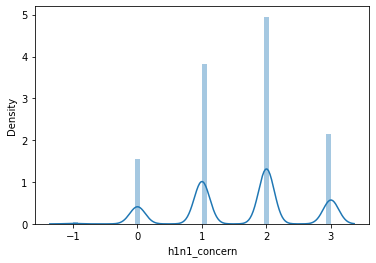

<Figure size 432x288 with 0 Axes>

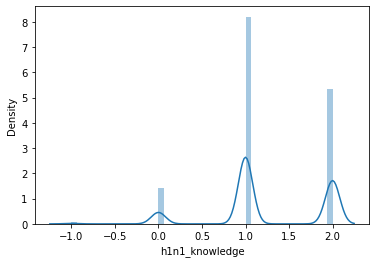

<Figure size 432x288 with 0 Axes>

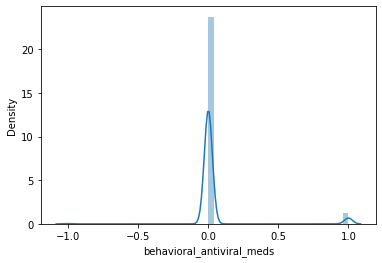

<Figure size 432x288 with 0 Axes>

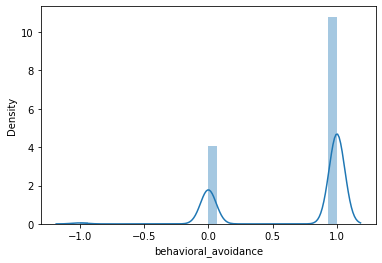

<Figure size 432x288 with 0 Axes>

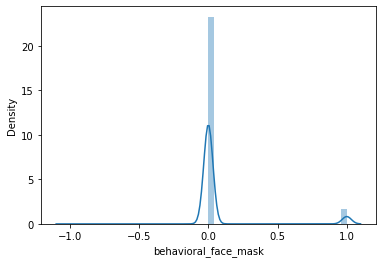

<Figure size 432x288 with 0 Axes>

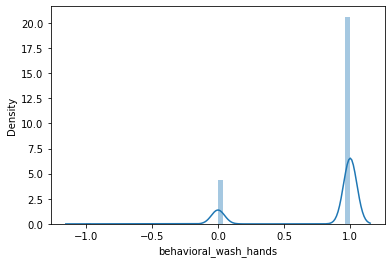

<Figure size 432x288 with 0 Axes>

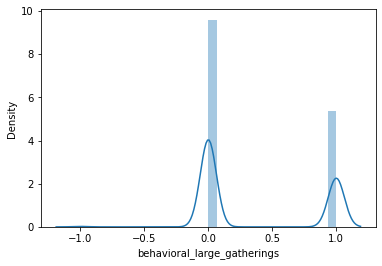

<Figure size 432x288 with 0 Axes>

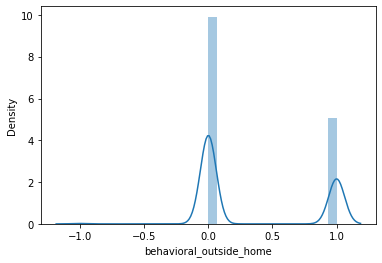

<Figure size 432x288 with 0 Axes>

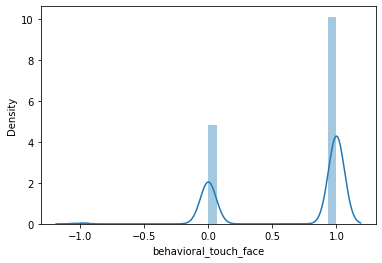

<Figure size 432x288 with 0 Axes>

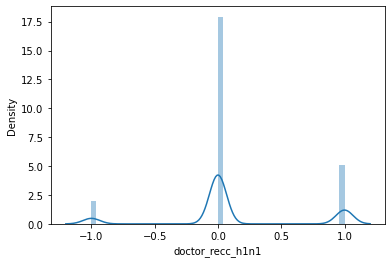

<Figure size 432x288 with 0 Axes>

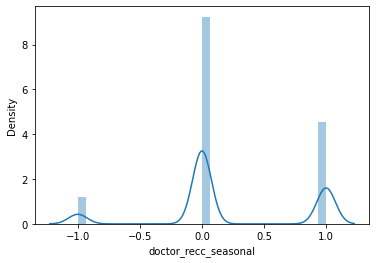

<Figure size 432x288 with 0 Axes>

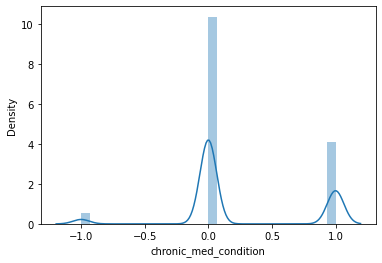

<Figure size 432x288 with 0 Axes>

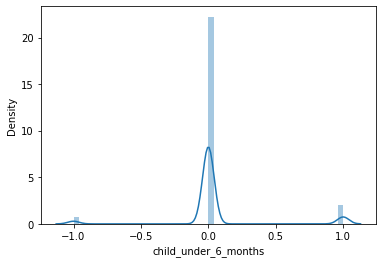

<Figure size 432x288 with 0 Axes>

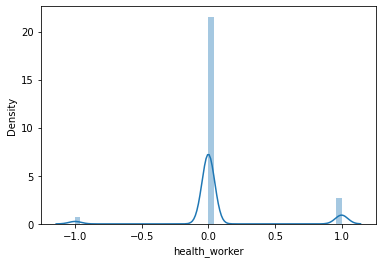

<Figure size 432x288 with 0 Axes>

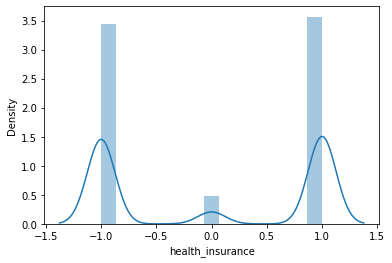

<Figure size 432x288 with 0 Axes>

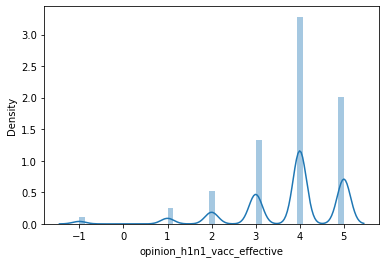

<Figure size 432x288 with 0 Axes>

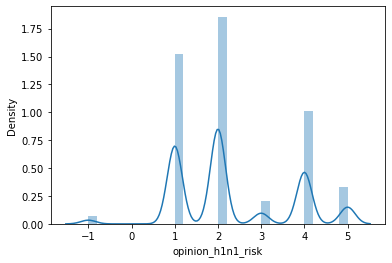

<Figure size 432x288 with 0 Axes>

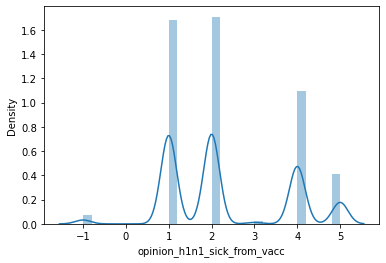

<Figure size 432x288 with 0 Axes>

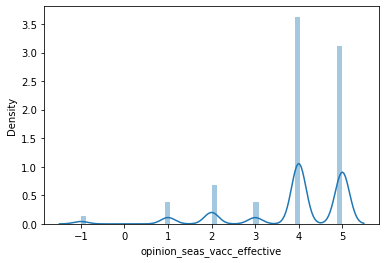

<Figure size 432x288 with 0 Axes>

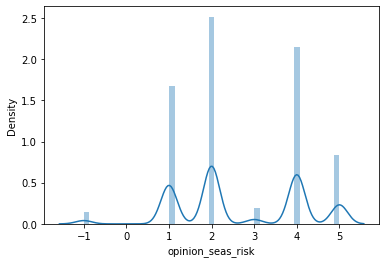

<Figure size 432x288 with 0 Axes>

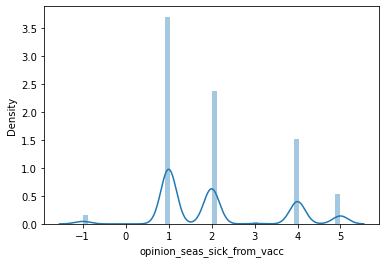

<Figure size 432x288 with 0 Axes>

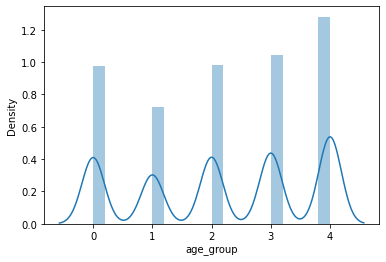

<Figure size 432x288 with 0 Axes>

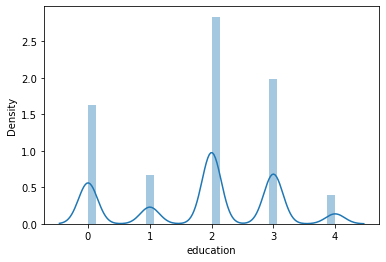

<Figure size 432x288 with 0 Axes>

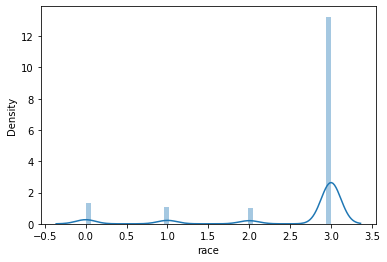

<Figure size 432x288 with 0 Axes>

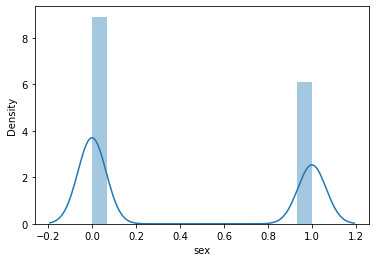

<Figure size 432x288 with 0 Axes>

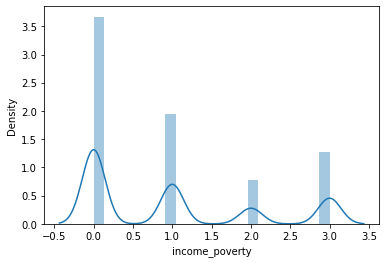

<Figure size 432x288 with 0 Axes>

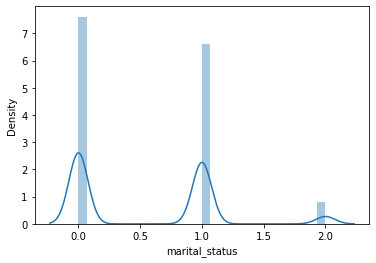

<Figure size 432x288 with 0 Axes>

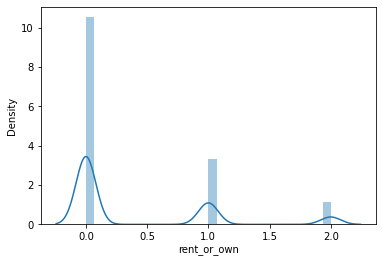

<Figure size 432x288 with 0 Axes>

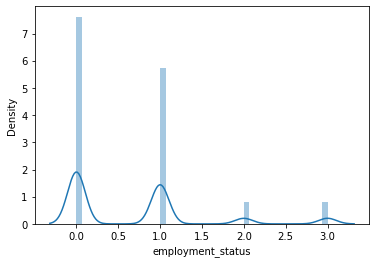

<Figure size 432x288 with 0 Axes>

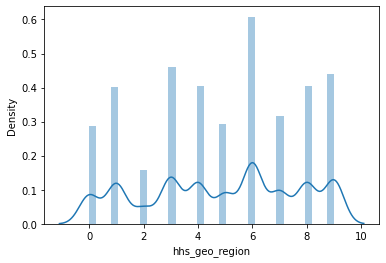

<Figure size 432x288 with 0 Axes>

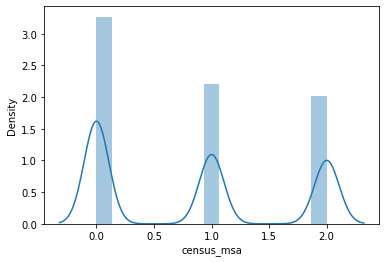

<Figure size 432x288 with 0 Axes>

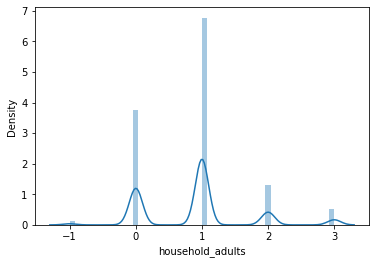

<Figure size 432x288 with 0 Axes>

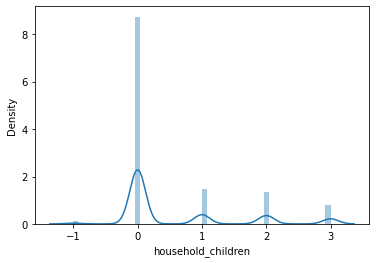

<Figure size 432x288 with 0 Axes>

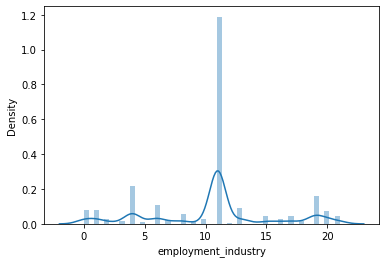

<Figure size 432x288 with 0 Axes>

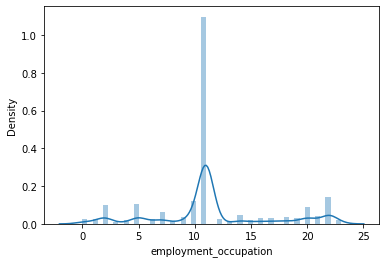

<Figure size 432x288 with 0 Axes>

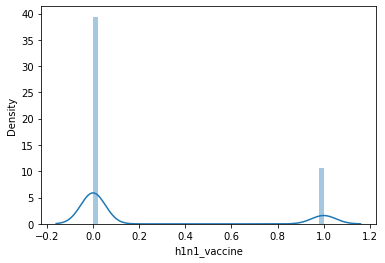

<Figure size 432x288 with 0 Axes>

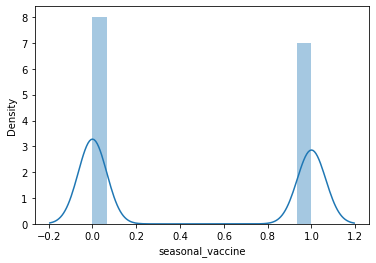

<Figure size 432x288 with 0 Axes>

In [10]:

# create distplots
for column in df_train.columns:
    plt.figure()            
    sns.distplot(df_train[column])
    plt.figure()

In [11]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26707 non-null  float64
 1   h1n1_knowledge               26707 non-null  float64
 2   behavioral_antiviral_meds    26707 non-null  float64
 3   behavioral_avoidance         26707 non-null  float64
 4   behavioral_face_mask         26707 non-null  float64
 5   behavioral_wash_hands        26707 non-null  float64
 6   behavioral_large_gatherings  26707 non-null  float64
 7   behavioral_outside_home      26707 non-null  float64
 8   behavioral_touch_face        26707 non-null  float64
 9   doctor_recc_h1n1             26707 non-null  float64
 10  doctor_recc_seasonal         26707 non-null  float64
 11  chronic_med_condition        26707 non-null  float64
 12  child_under_6_months         26707 non-null  float64
 13  health_worker   

Correlation Heatmap

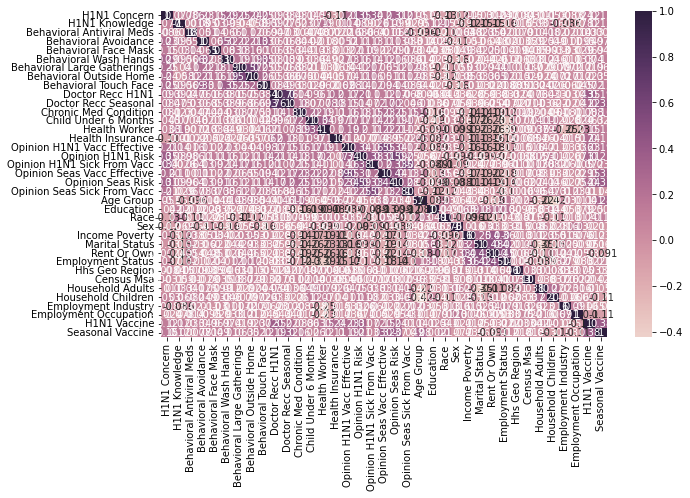

In [12]:
h_labels = [x.replace('_', ' ').title() for x in 
            list(df_train.select_dtypes(include=['number', 'bool']).columns.values)]
fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(df_train.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

Correlation Table 

In [13]:
df_train.corr()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
h1n1_concern,1.000000,0.076568,0.085562,0.230465,0.151493,0.289809,0.250078,0.240748,0.246532,0.092702,...,-0.002388,0.036798,-0.008409,0.003074,-0.011020,0.053092,-0.008264,-0.023937,0.120970,0.152583
h1n1_knowledge,0.076568,1.000000,-0.001816,0.095192,0.029994,0.094993,-0.039979,-0.057778,0.094727,0.092033,...,-0.150621,-0.160954,-0.015268,-0.059151,0.033406,0.060474,-0.085806,-0.078106,0.115295,0.116014
behavioral_antiviral_meds,0.085562,-0.001816,1.000000,0.051383,0.139040,0.065579,0.102030,0.121166,0.069112,0.047340,...,0.054453,0.020685,0.007902,0.010412,0.040948,0.081529,0.019574,0.013989,0.033279,0.000779
behavioral_avoidance,0.230465,0.095192,0.051383,1.000000,0.065182,0.319223,0.221717,0.213970,0.326056,0.061208,...,-0.048042,-0.019537,0.000348,-0.028952,0.025248,0.049375,-0.010883,-0.009453,0.048754,0.071148
behavioral_face_mask,0.151493,0.029994,0.139040,0.065182,1.000000,0.082940,0.175517,0.159806,0.104119,0.063318,...,0.051427,0.040285,0.009380,-0.003500,0.009870,0.003306,-0.030043,-0.028929,0.069268,0.049073
behavioral_wash_hands,0.289809,0.094993,0.065579,0.319223,0.082940,1.000000,0.189771,0.189296,0.350856,0.080813,...,-0.026052,-0.012318,-0.006257,-0.017941,0.011999,0.046350,-0.011029,-0.033039,0.074172,0.110889
behavioral_large_gatherings,0.250078,-0.039979,0.102030,0.221717,0.175517,0.189771,1.000000,0.568979,0.247078,0.057276,...,0.044068,0.102864,0.011214,0.036961,-0.028807,-0.007906,0.007214,0.011999,0.018719,0.062577
behavioral_outside_home,0.240748,-0.057778,0.121166,0.213970,0.159806,0.189296,0.568979,1.000000,0.261638,0.053033,...,0.064544,0.118961,0.014637,0.028628,-0.023710,-0.007198,0.016568,0.011824,0.022869,0.052399
behavioral_touch_face,0.246532,0.094727,0.069112,0.326056,0.104119,0.350856,0.247078,0.261638,1.000000,0.084245,...,-0.021028,0.008818,-0.005138,0.003222,0.004742,0.025994,-0.006232,-0.044981,0.072347,0.115772
doctor_recc_h1n1,0.092702,0.092033,0.047340,0.061208,0.063318,0.080813,0.057276,0.053033,0.084245,1.000000,...,-0.037702,-0.033312,-0.023561,-0.007562,0.034349,0.033375,-0.029806,-0.043021,0.353960,0.189412


Variance

In [14]:
df_train.var()

h1n1_concern                    0.849349
h1n1_knowledge                  0.402587
behavioral_antiviral_meds       0.049253
behavioral_avoidance            0.220567
behavioral_face_mask            0.064993
behavioral_wash_hands           0.148988
behavioral_large_gatherings     0.235270
behavioral_outside_home         0.228330
behavioral_touch_face           0.230957
doctor_recc_h1n1                0.268591
doctor_recc_seasonal            0.334589
chronic_med_condition           0.253347
child_under_6_months            0.108326
health_worker                   0.132504
health_insurance                0.934782
opinion_h1n1_vacc_effective     1.339503
opinion_h1n1_risk               1.788567
opinion_h1n1_sick_from_vacc     1.993946
opinion_seas_vacc_effective     1.589634
opinion_seas_risk               2.142554
opinion_seas_sick_from_vacc     1.932599
age_group                       2.123783
education                       1.407645
race                            0.852346
sex             

Balancing/Oversampling minority classes using SMOTE .

In [15]:
#df_labels
df_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,8.0,2.0,0.0,0.0,11.0,11.0,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,13.0,20.0,0.0,1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,9.0,0.0,2.0,0.0,15.0,22.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,5.0,1.0,0.0,0.0,11.0,11.0,0.0,1.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,9.0,0.0,1.0,0.0,19.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,9.0,2.0,0.0,0.0,11.0,11.0,0.0,0.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,6.0,1.0,1.0,0.0,4.0,2.0,0.0,0.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,3.0,6.0,0.0,0.0,0.0,11.0,11.0,0.0,1.0
26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,1.0,0.0,5.0,2.0,1.0,0.0,4.0,6.0,0.0,0.0


In [17]:


# transform the dataset
X = df_train.drop(columns = ['h1n1_vaccine','seasonal_vaccine'])
y_swine = df_train['h1n1_vaccine']
y_seasonal = df_train['seasonal_vaccine']
oversample = SMOTE()
X, y_swine = oversample.fit_resample(X, y_swine)
#TODO the y_seasonal data is missing for some records. Need to investigate and correct.
#X, y_seasonal = oversample.fit_resample(X, y_seasonal)

#Split the data TODO Split into 70 30 10 (train test and validation)
X_train, X_test, y_train_swine, y_test_swine = train_test_split(X,y_swine, train_size=.7)
#X_train, X_test, y_train_swine, y_test_swine = train_test_split(X,y_seasonal, train_size=.7)

## Model Strategies <a class="anchor" id="model"></a>

For the problem at hand, the most appropriate strategy was to fit a number of classification models to classify observations into vaccinated or un-vaccinated.

The following models were fit, tested, and tuned to produce the most accurate model possible based on F-1 score: neural network model, logistic regression, SVM, gradient boosting classifier, Gaussian Naive Bayes, KNN, Random Forest, and a boosted classifier.

In [18]:
#Neural Network Model
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter = 1000, random_state = 12345)
NN.fit(X_train, y_train_swine)
y_pred = NN.predict(X_test)
f1 = round(f1_score(y_test_swine, y_pred, average='macro'), 3)
print("\nNeural Network (using scaler inputs) f1 score: ", f1)
classificationSummary(y_test_swine, y_pred)

#Logistic Regression Model
logistic = LogisticRegressionCV(cv=5, penalty = 'l2', solver = 'liblinear',tol=1e-5,max_iter=1000,Cs=10, random_state = 12345)
logistic.fit(X_train, y_train_swine)
y_pred = logistic.predict(X_test)
f1 = round(f1_score(y_test_swine, y_pred, average='macro'), 3)
print("\nLogistic Regression (using scaler inputs) f1 score: ", f1)
classificationSummary(y_test_swine, y_pred)

#Support Vector Machine model
SVM = svm.LinearSVC(max_iter = 5000, penalty = 'l2', loss = 'hinge', random_state = 12345)
SVM.fit(X_train, y_train_swine)
y_pred = SVM.predict(X_test)
f1 = round(f1_score(y_test_swine, y_pred, average='macro'), 3)
print("\nSVM (using scaler inputs) f1 score: ", f1)
classificationSummary(y_test_swine, y_pred)

#Gradient Boosting Classifier
gb_classif = GradientBoostingClassifier()
gb_classif.fit(X_train, y_train_swine)
y_pred = gb_classif.predict(X_test)
f1 = round(f1_score(y_test_swine, y_pred, average='macro'), 3)
print("\nGradientBoosting (using scaler inputs) f1 score: ", f1)
classificationSummary(y_test_swine, y_pred)

#Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train_swine)
y_pred = gnb.predict(X_test)
f1 = round(f1_score(y_test_swine, y_pred, average='macro'), 3)
print("\nNaive Bayes (using scaler inputs) f1 score: ", f1)
classificationSummary(y_test_swine, y_pred)

#K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3, weights = 'distance')
knn.fit(X_train, y_train_swine)
y_pred = knn.predict(X_test)
f1 = round(f1_score(y_test_swine, y_pred, average='macro'), 3)
print("\nKNN f1 score: ", f1)
classificationSummary(y_test_swine, y_pred)

#Random Forest model
rf = RandomForestClassifier(max_depth=2, random_state = 12345)
rf.fit(X_train, y_train_swine)
y_pred = rf.predict(X_test)
f1 = round(f1_score(y_test_swine, y_pred, average='macro'), 3)
print("\nRandom Forest f1 score: ", f1)
classificationSummary(y_test_swine, y_pred)


Neural Network (using scaler inputs) f1 score:  0.331
Confusion Matrix (Accuracy 0.4945)

       Prediction
Actual    0    1
     0    0 6380
     1    0 6240

Logistic Regression (using scaler inputs) f1 score:  0.785
Confusion Matrix (Accuracy 0.7848)

       Prediction
Actual    0    1
     0 5046 1334
     1 1382 4858


C:\Users\elfek\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



SVM (using scaler inputs) f1 score:  0.79
Confusion Matrix (Accuracy 0.7899)

       Prediction
Actual    0    1
     0 5137 1243
     1 1409 4831

GradientBoosting (using scaler inputs) f1 score:  0.907
Confusion Matrix (Accuracy 0.9076)

       Prediction
Actual    0    1
     0 6033  347
     1  819 5421

Naive Bayes (using scaler inputs) f1 score:  0.752
Confusion Matrix (Accuracy 0.7517)

       Prediction
Actual    0    1
     0 4584 1796
     1 1338 4902

KNN f1 score:  0.805
Confusion Matrix (Accuracy 0.8101)

       Prediction
Actual    0    1
     0 4115 2265
     1  131 6109

Random Forest f1 score:  0.827
Confusion Matrix (Accuracy 0.8269)

       Prediction
Actual    0    1
     0 5439  941
     1 1243 4997


In [19]:
#Find best paramters of Adaboost TODO using random search instead of grid search
boost_grid = {
    'n_estimators': [50, 100, 200, 400],
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0]
}

boost_gridSearch = GridSearchCV(AdaBoostClassifier(), boost_grid, cv = 3)
boost_gridSearch.fit(X_train, y_train_swine)

print('Initial Adaboost Parameters:', boost_gridSearch.best_params_)

Initial Adaboost Parameters: {'learning_rate': 1.0, 'n_estimators': 400}


Confusion Matrix of Best Performing Model (Adaboost or Gradiantboost I think but we need to tinker with the hyperparameters).

In [21]:
#Boosted Classifier
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), learning_rate = 1.5, n_estimators=400, random_state = 12345)
adaboost.fit(X_train, y_train_swine)
y_pred = adaboost.predict(X_test)
f1 = round(f1_score(y_test_swine, y_pred, average='macro'), 3)
print("\nAdaboost f1 score: ", f1)
#classificationSummary(y_test, y_pred)




Adaboost f1 score:  0.898


<AxesSubplot:>

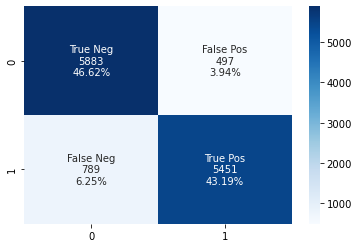

In [22]:
#Create plot of the confusion matrix, showing performance of the model
cm = confusion_matrix(y_test_swine, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

## Results and Conclusions <a class="anchor" id="results"></a>

The final results indicate that the best model for predicting...